In [1]:
import Pkg
Pkg.activate("packages")
Pkg.instantiate()
using CSV, DataFrames, Plots, Plots.PlotMeasures, StatsPlots, Statistics

  Activating environment at `~/Documents/Still evolving/Quantifying-SIM-exp/packages/Project.toml`
Precompiling project...
  ✓ PrecompileTools
  ✓ JLLWrappers
  ✓ libevdev_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ mtdev_jll
  ✓ FriBidi_jll
  ✓ LZO_jll
  ✓ Libuuid_jll
  ✓ libaom_jll
  ✓ RecipesBase
  ✓ StringManipulation
  ✓ Xorg_xtrans_jll
  ✓ Libffi_jll
  ✓ x264_jll
  ✓ fzf_jll
  ✓ libsodium_jll
  ✓ LAME_jll
  ✓ libfdk_aac_jll
  ✓ Libgpg_error_jll
  ✓ Zstd_jll
  ✓ Wayland_protocols_jll
  ✓ Libmount_jll
  ✓ LERC_jll
  ✓ Graphite2_jll
  ✓ Rmath_jll
  ✓ IntelOpenMP_jll
  ✓ Libiconv_jll
  ✓ libpng_jll
  ✓ FFTW_jll
  ✓ gperf_jll
  ✓ Opus_jll
  ✓ Bzip2_jll
  ✓ Xorg_libXdmcp_jll
  ✓ EpollShim_jll
  ✓ LLVMOpenMP_jll
  ✓ x265_jll
  ✓ Xorg_libXau_jll
  ✓ JpegTurbo_jll
  ✓ OpenSSL_jll
  ✓ JLFzf
  ✓ Expat_jll
  ✓ Ogg_jll
  ✓ XZ_jll
  ✓ OpenSpecFun_jll
  ✓ ZeroMQ_jll
  ✓ Libgcrypt_jll
  ✓ Rmath
  ✓ MKL_jll
  ✓ eudev_jll
  ✓ XML2_jll
  ✓ FreeType2_jll
  ✓ Pixman_jll
  ✓ libvorbis_jll
  ✓ libinput_jll
 

In [2]:
my_col = cgrad(:tol_bright, categorical=true, 17)

### Figure 2: Quantification of the accuray and precision of our inference method using simulated mutant count data

In [72]:
# Reading the (true) input parameters
p = "range_mu-inc"
p2 = "range_switching"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) / true_para_1.divisions_off[1]
range_para_2 = 10 .^ collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1]) / true_para_1.divisions_off[1]
J1 = length(range_para_1)
J2 = length(range_para_2)
mu_off_true = true_para_1.mutations_off[1] / true_para_1.divisions_off[1];

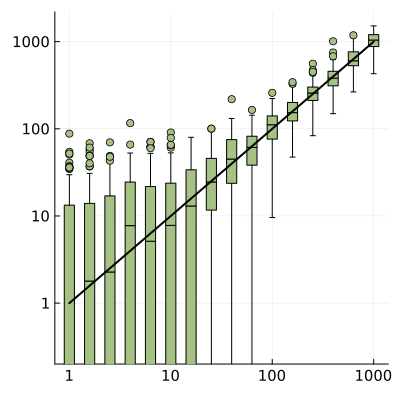

In [4]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated compared to true mutation-rate increase for switching=0.01
m = "het_zero_div"
P_inc = plot(size=(400,400))
r = 11
for j1 = 1:2:J1
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$j1.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j1], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(Int.(range_para_1[1:10:J1]), Int.(range_para_1[1:10:J1])), yscale=:log10, ylim=(0.2, 2200))
plot!(range_para_1, c=:black, width=2, lab="", tickfontsize=10, draw_arrow=true)
#plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(range_para_2[r], digits=3))")

In [5]:
# Determining numerical values for the precision
i = 21
inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv")), :AIC => ByRow(a->!isinf(a)))
println("True mutation-rate increase = ", range_para_1[i])
println("25 and 75 percent quantiles: ", quantile(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, [0.25,0.75])/ range_para_1[i])
println("")
i = 15
inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv")), :AIC => ByRow(a->!isinf(a)))
println("True mutation-rate increase = ", range_para_1[i])
q2, q4 = quantile(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, [0.25, 0.75])
IQR = q4 - q2
println("Maximum estimated mutation-rate = ", maximum((inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off)[inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off .< q4 + 1.5*IQR]))

True mutation-rate increase = 100.0
25 and 75 percent quantiles: [0.7626096140322298, 1.4070613262564415]

True mutation-rate increase = 25.118864315095795
Maximum estimated mutation-rate = 95.32847909768472


In [73]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Relative error and coefficient of variation across the estimates
m = "het_zero_div"
RE_alpha_mu = Matrix{Float64}(undef, (J2, J1))
CV_alpha_mu = Matrix{Float64}(undef, (J2, J1))
for j2 = 1:J2
    p_folder = "/switch_$j2"
    for j1 = 1:J1
        inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*p_folder*"/"*m*"_$j1.csv")), :AIC => ByRow(a->!isinf(a)))
        RE_alpha_mu[j2, j1] = (median(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off) - range_para_1[j1]) / range_para_1[j1]
        CV_alpha_mu[j2, j1] = std(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off) / mean(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off)
    end
end

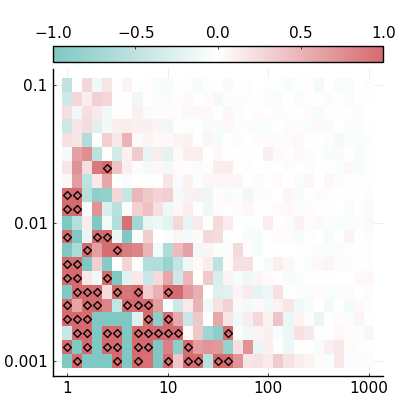

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [75]:
pyplot()
c_max = 1
c_min = -1
P_RE = plot(size=(400,400))
heatmap!(RE_alpha_mu, c=cgrad([my_col[11], :white, my_col[4]], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max), cb=:top, colorbar_tickfontsize=11)
for i = 1:size(RE_alpha_mu)[2]
    for j = 1:size(RE_alpha_mu)[1]
        if abs(RE_alpha_mu[j,i]) > 1
            scatter!([i], [j], lab="", c=my_col[4], marker=:diamond)
        end
    end
end 
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=11)
#plot!(title="Relative error (median)", xlab="Mutation-rate increase", ylab="Relative switching rate")

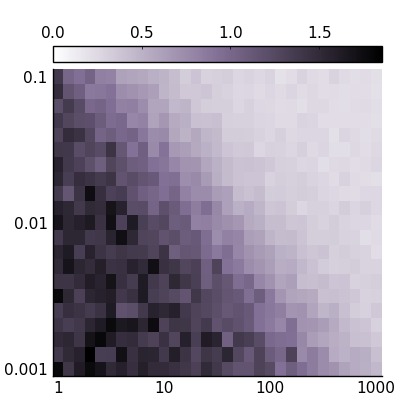

In [76]:
P_CV = plot(size=(400,400))
heatmap!(CV_alpha_mu, c=cgrad([:white, my_col[2], :black]), clim=(0, 1.85), cb=:top, colorbar_tickfontsize=11)
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=11)
#plot!(title="Coefficient of variation", xlab="Mutation-rate increase", ylab="Relative switching rate")

In [78]:
savefig(P_inc, "figures/Figure_2A.pdf")
savefig(P_RE, "figures/Figure_2B.png")
savefig(P_CV, "figures/Figure_2C.png")
gr()

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Plots.GRBackend()

### Figure 3: Impact of cell death on the estimation of the mutation-rate increase

In [124]:
# Reading the (true) input parameters
p = "range_death-off_switch-5"
p2 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

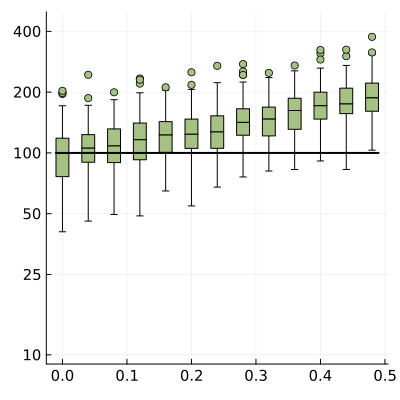

In [125]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off = plot(size=(400,400))
r = 1
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(title="Death only in response-off cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


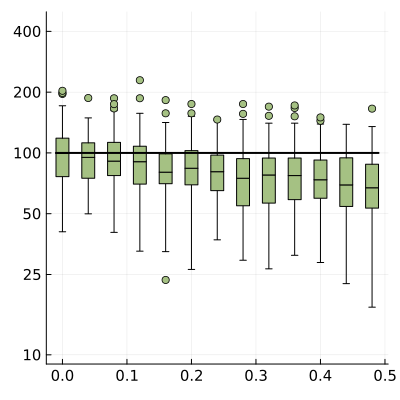

In [126]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on = plot(size=(400,400))
r = 1
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(title="Death only in response-on cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase")

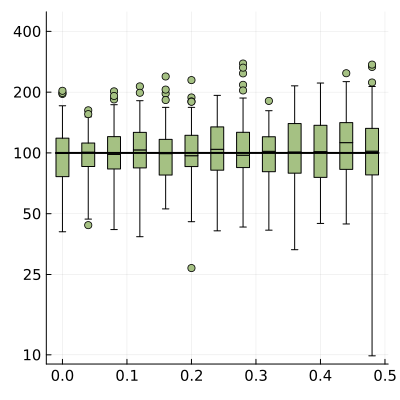

In [127]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(title="Death in all cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase")

In [128]:
savefig(P_inc_off, "figures/Figure_3A.pdf")
savefig(P_inc_on, "figures/Figure_3B.pdf")
savefig(P_inc_all, "figures/Figure_3C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_3C.pdf"

#### Appendix Figure: Impact of cell death for different switching rates

In [167]:
# Reading the (true) input parameters
# Switching rate = 0.01 and 0.05
p_1 = "range_death-off_switch-1"
p2_1 = "range_death-on_switch-1"
p_5 = "range_death-off_switch-5"
p2_5 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

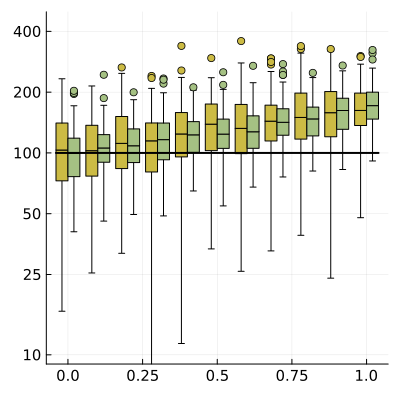

In [168]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off_A = plot(size=(400,400))
r = 1
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=my_col[9])
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=my_col[10])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(title="Death only in response-off cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:bottomright)
#scatter!([0], [1], lab="Rel. switching rate = 0.01", c=my_col[9], marker=:square)
#scatter!([0], [1], lab="Rel. switching rate = 0.05", c=my_col[10], marker=:square)

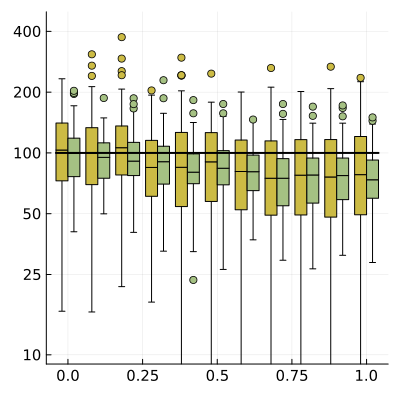

In [169]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on_A = plot(size=(400,400))
r = 1
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=my_col[9])
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=my_col[10])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(title="Death only in response-on cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:topleft)
#scatter!([0], [1], lab="Rel. switching rate = 0.01", c=my_col[9], marker=:square)
#scatter!([0], [1], lab="Rel. switching rate = 0.05", c=my_col[10], alpha=0.7, marker=:square)

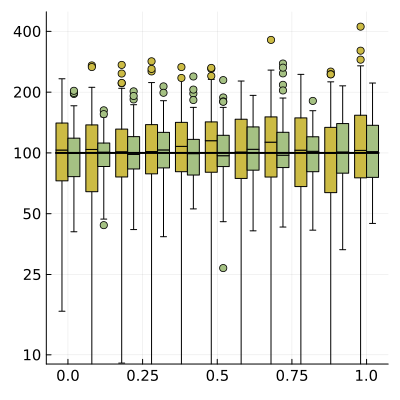

In [170]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all_A = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=my_col[9])
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=my_col[10])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(title="Death only in all cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:topleft)
#scatter!([0], [1], lab="Rel. switching rate = 0.01", c=my_col[9], marker=:square)
#scatter!([0], [1], lab="Rel. switching rate = 0.05", c=my_col[10], marker=:square)

In [171]:
savefig(P_inc_off_A, "figures/Figure_A_2A.pdf")
savefig(P_inc_on_A, "figures/Figure_A_2B.pdf")
savefig(P_inc_all_A, "figures/Figure_A_2C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_2C.pdf"

#### Appendix Figure: Impact of differential fitness of mutants on the estimation of the mutation-rate increase

In [139]:
# Reading the (true) input parameters
p = "range_fit-mut"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1])
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

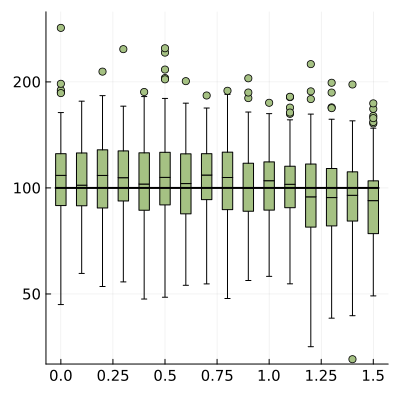

In [140]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
m = "het_zero_div"
P_inc_fit = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$(J-j+1).csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[J:-5:1]), yscale=:log10, ylim=(10^1.5, 10^2.5), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Differential fitness of mutants", ylab="Estimated mutation-rate increase")

In [141]:
savefig(P_inc_fit, "figures/Figure_A_3.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_3.pdf"

### Figure 4: Estimation when response-on cells have a non-zero division rate.

In [196]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
R = true_para.number_fluctuation_assays[1];


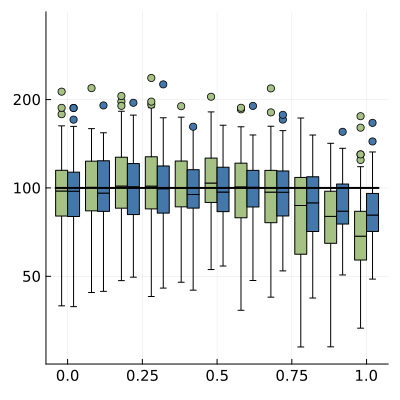

In [197]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
P_inc_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=my_col[10])
    boxplot!([j+0.4], inferred_para_2.mutation_rate_on ./ inferred_para_2.mutation_rate_off, lab="", c=my_col[1])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Rel. fitness of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Rel. fitness set to zero", c=my_col[10], marker=:square)
#scatter!([0], [1], lab="Rel. fitness inferred", c=my_col[1], marker=:square)

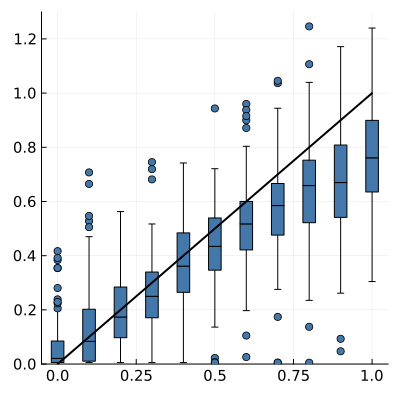

In [198]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, inferring the rel. division rate, known f_on
# Estimated compared to true rel. division rate of response-on cells
m = "het_infer_div"
P_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.division_rate_on, lab="", c=my_col[1])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.3))
plot!(collect(1:J), range_para, lab="", c=:black, width=2, tickfontsize=10)
#plot!(xlab="True rel. fitness of response-on cells", ylab="Estimated rel. fitness of response-on cells")

In [199]:
savefig(P_inc_div, "figures/Figure_4A.pdf")
savefig(P_div, "figures/Figure_4B.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_4B.pdf"

#### Appendix Figure: Estimation when response-on cells have a (known) non-zero division rate.

In [161]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

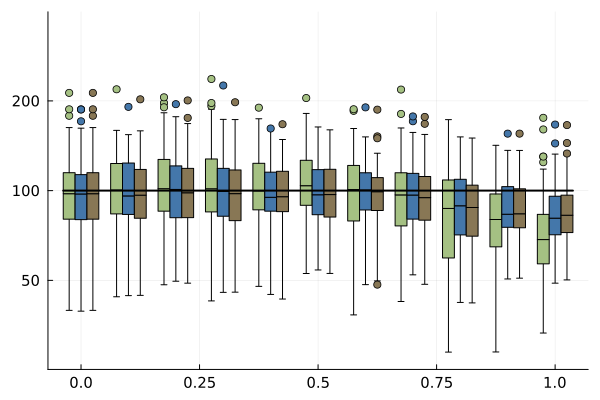

In [163]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# (iii) setting the rel. division rate to its true value
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
m_3 = "het_set_div"
P_inc_div_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_3 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_3*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.5], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=my_col[10], bar_width=0.5)
    boxplot!([j], inferred_para_2.mutation_rate_on ./ inferred_para_2.mutation_rate_off, lab="", c=my_col[1], bar_width=0.5)
    boxplot!([j+0.5], inferred_para_3.mutation_rate_on ./ inferred_para_3.mutation_rate_off, lab="", c=my_col[5], bar_width=0.5)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Rel. fitness set to zero", c=my_col[10], marker=:square)
#scatter!([0], [1], lab="Rel. fitness inferred", c=my_col[1], marker=:square)
#scatter!([0], [1], lab="Rel. fitness set to true value", c=my_col[5], marker=:square)

In [152]:
savefig(P_inc_div_A, "figures/Figure_A_4.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_4.pdf"

### Figure 5: Model selection heterogeneous-response model - homogeneous-response model

In [273]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];
     

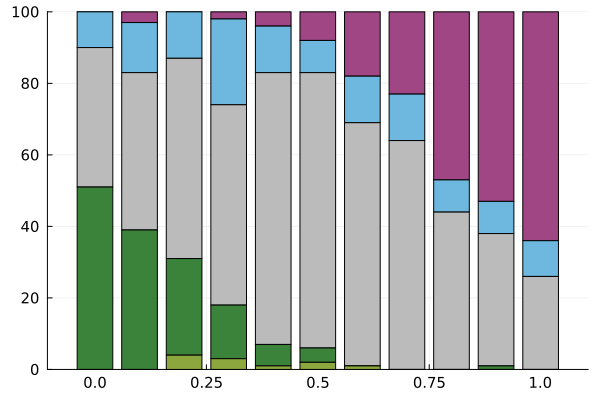

In [274]:
# Reading AIC values and selecting a model
# (i) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (ii) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
# (iii) Homogeneous-response model with fitness of mutants set to one
# (iv) Homogeneous-response model with fitnesses of mutants permissive/stressful inferred
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_infer_fit"
select_het_1 = Vector{Int}(undef, J)
select_het_2 = Vector{Int}(undef, J)
select_hom_1 = Vector{Int}(undef, J)
select_hom_2 = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv")).AIC
    AIC_12 = AIC_1 .- AIC_2
    AIC_hom = minimum([AIC_1 AIC_2], dims=2)
    AIC_3 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv")).AIC
    AIC_4 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv")).AIC
    AIC_34 = AIC_3 .- AIC_4
    AIC_het = minimum([AIC_3 AIC_4], dims=2)
    AIC_diff = AIC_het .- AIC_hom
    select_hom_1[j] = sum( (AIC_diff .> 2) .* (AIC_12 .< 0))
    select_hom_2[j] = sum( (AIC_diff .> 2) .* (AIC_12 .> 0))
    select_het_1[j] = sum( (AIC_diff .< -2) .* (AIC_34 .< 0))
    select_het_2[j] = sum( (AIC_diff .< -2) .* (AIC_34 .> 0))
    select_none[j] = R - select_hom_1[j] - select_hom_2[j] - select_het_1[j] - select_het_2[j]
end
P_AIC = groupedbar([select_hom_1[1:2:J] select_hom_2[1:2:J] select_none[1:2:J] select_het_1[1:2:J] select_het_2[1:2:J]], bar_position=:stack, c=[my_col[14] my_col[12] my_col[17] my_col[6] my_col[8]], label=["Homogeneous response (mutant fitness set to one)" "Homogeneous response (mutant fitnesses permissive/stressful inferred)" "None" "Heterogeneous response (rel. fitness set to zero)" "Heterogeneous response (rel. fitness inferred)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=10)
plot!(legend=false)
#plot!(xlab="Relative fitness of response-on cells", ylab="Percentage of simulations", legend=:outertop, legend_title="Preferred model")

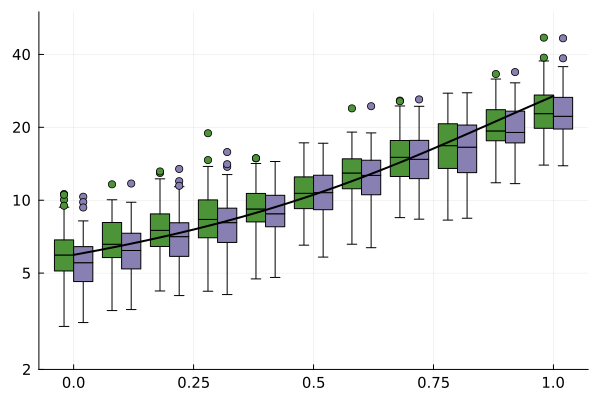

In [275]:
# Reading and plotting the inferred parameters
# Estimation methods:
# (i) Heterogeneous-response model (unknown f_on)
# (ii) Homogeneous-response model
# Estimated population-wide mutation-rate increase 
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_infer_fit"
P_mean = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv"))
    inferred_para_het_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv"))
    inferred_para_het_1.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het_2.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het = vcat(subset(inferred_para_het_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_het_2, :AIC_diff => ByRow(a->a>0.)))
    inferred_para_hom_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv"))
    inferred_para_hom_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv"))
    inferred_para_hom_1.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom_2.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom = vcat(subset(inferred_para_hom_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_hom_2, :AIC_diff => ByRow(a->a>0.)))
    boxplot!([j-0.4], (inferred_para_het.mutation_rate_on .* inferred_para_het.fraction_on .+ inferred_para_het.mutation_rate_off .* (1 .- inferred_para_het.fraction_on)) ./ inferred_para_het.mutation_rate_off, lab="", c=my_col[7])
    boxplot!([j+0.4], inferred_para_hom.mutation_rate_s ./ inferred_para_hom.mutation_rate_p, lab="", c=my_col[13])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2, 60), yticks=([1,2,5,10,20,40], [1,2,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Best-fitting heterogeneous-response model", c=my_col[7], marker=:square)
#scatter!([0], [0.1], lab="Best-fitting homogeneous-response model", c=my_col[13], marker=:square)

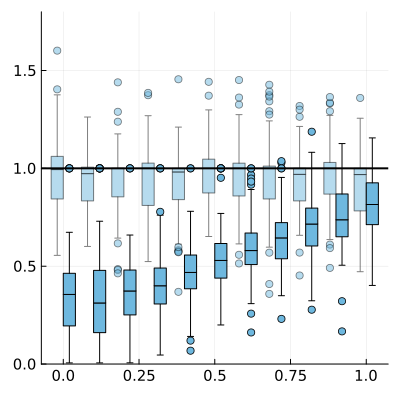

In [276]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with fitnesses of mutants permissive/stressful inferred
# Estimated mutant fitness
m = "hom_infer_fit"
P_rho = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para.fitness_mutants_p, lab="", c=my_col[12], alpha=0.5)
    boxplot!([j+0.4], inferred_para.fitness_mutants_s, lab="", c=my_col[12])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.8))
hline!([1], c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness")
#scatter!([0], [-1], lab="Permissive condition", c=:red, alpha=0.5, marker=:square)
#scatter!([0], [-1], lab="Stressful condition", c=:red, marker=:square)

In [277]:
savefig(P_AIC, "figures/Figure_5A.pdf")
savefig(P_mean, "figures/Figure_5B.pdf")
savefig(P_rho, "figures/Figure_5C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_5C.pdf"

### Appendix Figure: Model selection heterogeneous-response model - homogeneous-response model with constrained differential fitness of mutants

In [48]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) ./ true_para.divisions_off
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];

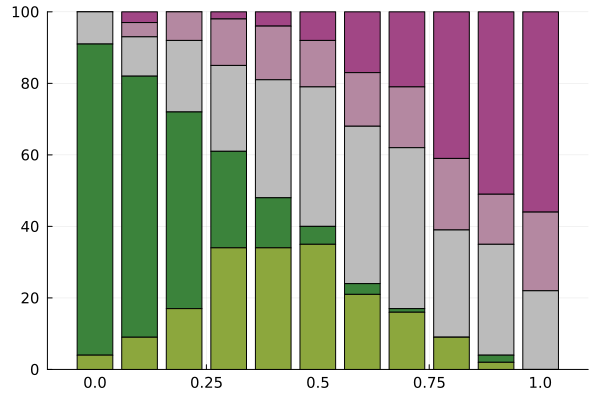

In [50]:
# Reading AIC values and selecting a model
# (i) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (ii) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
# (iii) Homogeneous-response model with fitness of mutants set to one
# (iv) Homogeneous-response model with jointly inferred fitness of mutants
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_joint_fit"
select_het_1 = Vector{Int}(undef, J)
select_het_2 = Vector{Int}(undef, J)
select_hom_1 = Vector{Int}(undef, J)
select_hom_2 = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv")).AIC
    AIC_12 = AIC_1 .- AIC_2
    AIC_hom = minimum([AIC_1 AIC_2], dims=2)
    AIC_3 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv")).AIC
    AIC_4 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv")).AIC
    AIC_34 = AIC_3 .- AIC_4
    AIC_het = minimum([AIC_3 AIC_4], dims=2)
    AIC_diff = AIC_het .- AIC_hom
    select_hom_1[j] = sum( (AIC_diff .> 2) .* (AIC_12 .< 0))
    select_hom_2[j] = sum( (AIC_diff .> 2) .* (AIC_12 .> 0))
    select_het_1[j] = sum( (AIC_diff .< -2) .* (AIC_34 .< 0))
    select_het_2[j] = sum( (AIC_diff .< -2) .* (AIC_34 .> 0))
    select_none[j] = R - select_hom_1[j] - select_hom_2[j] - select_het_1[j] - select_het_2[j]
end
P_AIC_A = groupedbar([select_hom_1[1:2:J] select_hom_2[1:2:J] select_none[1:2:J] select_het_1[1:2:J] select_het_2[1:2:J]], bar_position=:stack, c=[my_col[14] my_col[16] my_col[17] my_col[6] my_col[8]], label=["Homogeneous response (mutant fitness set to one)" "Homogeneous response (constrained mutant fitness inferred)" "None" "Heterogeneous response (rel. fitness set to zero)" "Heterogeneous response (rel. fitness inferred)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=10)
plot!(legend=false)
#plot!(xlab="Relative fitness of response-on cells", ylab="Percentage of simulations", legend=:outertop, legend_title="Preferred model")

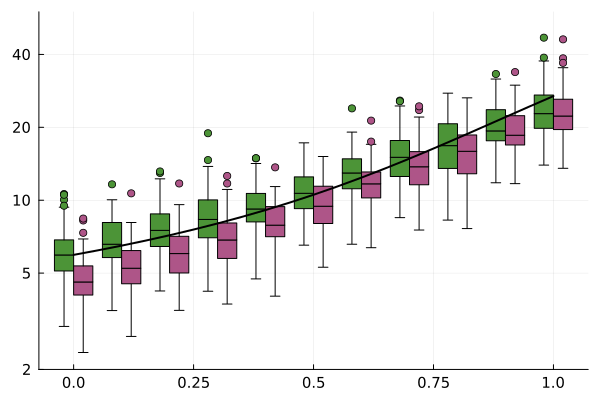

In [204]:
# Reading and plotting the inferred parameters
# Estimation methods:
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with fitness of mutants permissive/stressful inferred
# Estimated population-wide mutation-rate increase 
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_joint_fit"
P_mean_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv"))
    inferred_para_het_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv"))
    inferred_para_het_1.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het_2.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het = vcat(subset(inferred_para_het_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_het_2, :AIC_diff => ByRow(a->a>0.)))
    inferred_para_hom_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv"))
    inferred_para_hom_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv"))
    inferred_para_hom_1.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom_2.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom = vcat(subset(inferred_para_hom_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_hom_2, :AIC_diff => ByRow(a->a>0.)))
    boxplot!([j-0.4], (inferred_para_het.mutation_rate_on .* inferred_para_het.fraction_on .+ inferred_para_het.mutation_rate_off .* (1 .- inferred_para_het.fraction_on)) ./ inferred_para_het.mutation_rate_off, lab="", c=my_col[7])
    boxplot!([j+0.4], inferred_para_hom.mutation_rate_s ./ inferred_para_hom.mutation_rate_p, lab="", c=my_col[15])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2, 60), yticks=([1,2,5,10,20,40], [1,2,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Best-fitting heterogeneous-response model", c=my_col[7], marker=:square)
#scatter!([0], [0.1], lab="Best-fitting homogeneous-response model", c=my_col[15], marker=:square)

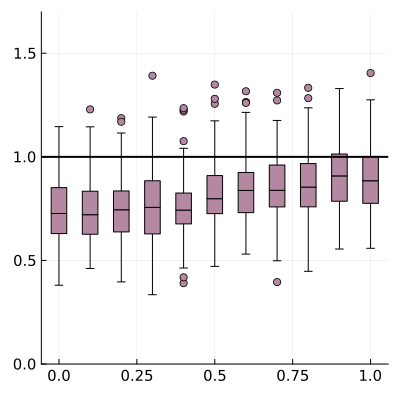

In [206]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with jointly inferred fitness of mutants 
# Estimated mutant fitness
m = "hom_joint_fit"
P_rho_A = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.fitness_mutants_s, lab="", c=my_col[16], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.7))
hline!([1], c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness")
#scatter!([0], [-1], lab="Permissive and stressful condition", c=my_col[16], marker=:square)

In [51]:
savefig(P_AIC_A, "figures/Figure_A_5A.pdf")
savefig(P_mean_A, "figures/Figure_A_5B.pdf")
savefig(P_rho_A, "figures/Figure_A_5C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_5A.pdf"

### Appendix Figure: Estimation using the heterogeneous/homogeneous-response model when the fraction of the response-on subpopulation is unknown

In [185]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];
     

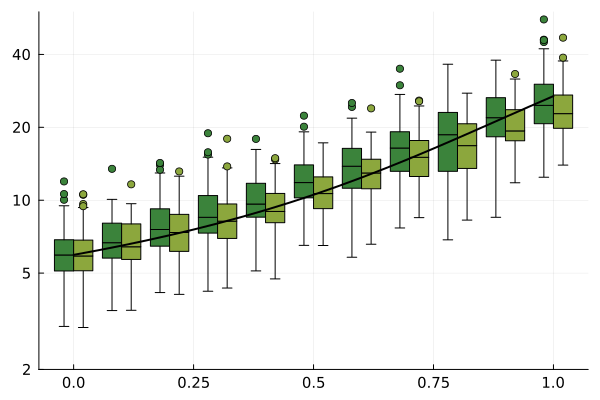

In [208]:
# Reading and plotting the inferred parameters
# Estimation methods:
# (i) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (ii) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
# Estimated population-wide mutation-rate increase 
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
P_mean_het = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_het_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], (inferred_para_het_1.mutation_rate_on .* inferred_para_het_1.fraction_on .+ inferred_para_het_1.mutation_rate_off .* (1 .- inferred_para_het_1.fraction_on)) ./ inferred_para_het_1.mutation_rate_off, lab="", c=my_col[6])
    boxplot!([j+0.4], (inferred_para_het_2.mutation_rate_on .* inferred_para_het_2.fraction_on .+ inferred_para_het_2.mutation_rate_off .* (1 .- inferred_para_het_2.fraction_on)) ./ inferred_para_het_2.mutation_rate_off, lab="", c=my_col[8])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2, 60), yticks=([1,2,5,10,20,40], [1,2,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Heterogeneous response (relative fitness set to zero)", c=my_col[6], marker=:square)
#scatter!([0], [0.1], lab="Heterogeneous response (relative fitness inferred)", c=my_col[8], marker=:square)


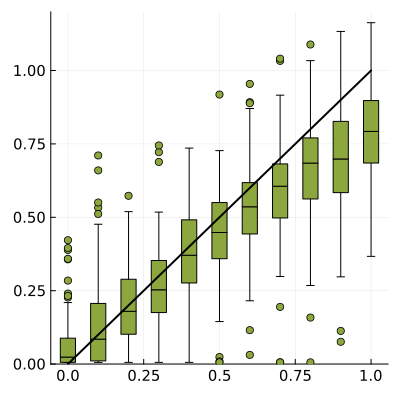

In [209]:
# Reading and plotting the inferred parameters
# Estimation method: Heterogeneous-response model with inferred relative fitness of response-on cells 
# Estimated relative fitness of response-on cells
m = "het_unknown_fraction_infer_div"
P_r = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.division_rate_on, lab="", c=my_col[8], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.2))
plot!(collect(1:J), range_para, lab="", c=:black, width=2, tickfontsize=10)
#plot!(xlab="True rel. fitness of response-on cells", ylab="Estimated rel. fitness of response-on cells")

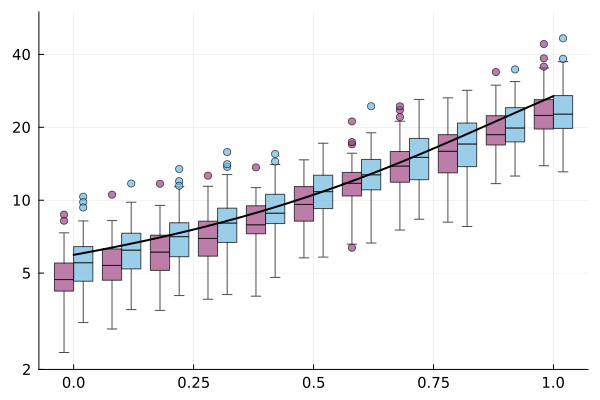

In [210]:
# Reading and plotting the inferred parameters
# Estimation methods:
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with fitnesses of mutants permissive/stressful inferred
# Estimated population-wide mutation-rate increase 
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_infer_fit"
P_mean_hom = plot(size=(600,400))
for j = 1:2:J
    inferred_para_hom_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_hom_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para_hom_1.mutation_rate_s ./ inferred_para_hom_1.mutation_rate_p, lab="", c=my_col[14], alpha=0.7)
    boxplot!([j+0.4], inferred_para_hom_2.mutation_rate_s ./ inferred_para_hom_2.mutation_rate_p, lab="", c=my_col[12], alpha=0.7)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2, 60), yticks=([1,2,5,10,20,40], [1,2,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Homogeneous response (mutant fitness set to one)", c=my_col[14], marker=:square)
#scatter!([0], [0.1], lab="Homogeneous response (mutant fitnesses permissive/stressful inferred)", c=my_col[12], marker=:square)


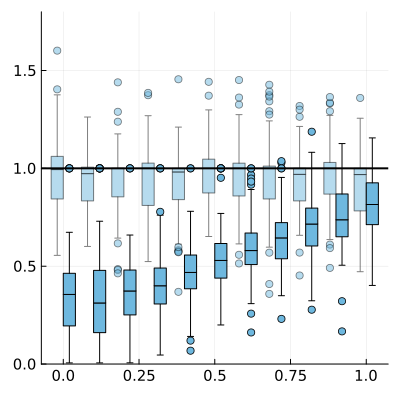

In [211]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with fitnesses of mutants permissive/stressful inferred
# Estimated mutant fitness
m = "hom_infer_fit"
P_rho = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para.fitness_mutants_p, lab="", c=my_col[12], alpha=0.5)
    boxplot!([j+0.4], inferred_para.fitness_mutants_s, lab="", c=my_col[12])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.8))
hline!([1], c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness")
#scatter!([0], [-1], lab="Permissive condition", c=:red, alpha=0.5, marker=:square)
#scatter!([0], [-1], lab="Stressful condition", c=:red, marker=:square)

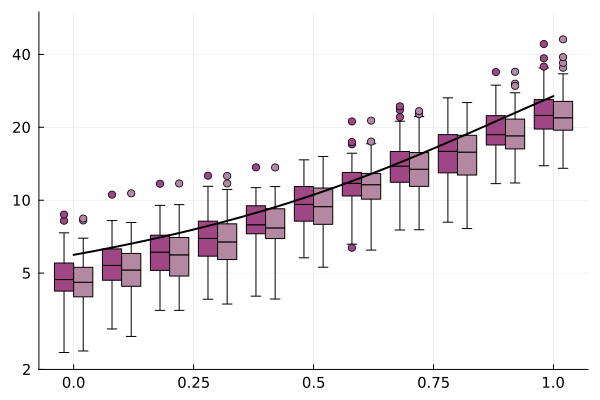

In [212]:
# Reading and plotting the inferred parameters
# Estimation methods:
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with constrained fitness of mutants permissive/stressful inferred
# Estimated population-wide mutation-rate increase 
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_joint_fit"
P_mean_hom_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_hom_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_hom_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para_hom_1.mutation_rate_s ./ inferred_para_hom_1.mutation_rate_p, lab="", c=my_col[14])
    boxplot!([j+0.4], inferred_para_hom_2.mutation_rate_s ./ inferred_para_hom_2.mutation_rate_p, lab="", c=my_col[16])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2, 60), yticks=([1,2,5,10,20,40], [1,2,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Homogeneous response (mutant fitness set to one)", c=my_col[14], marker=:square)
#scatter!([0], [0.1], lab="Homogeneous response (constrained mutant fitness inferred)", c=my_col[16], marker=:square)

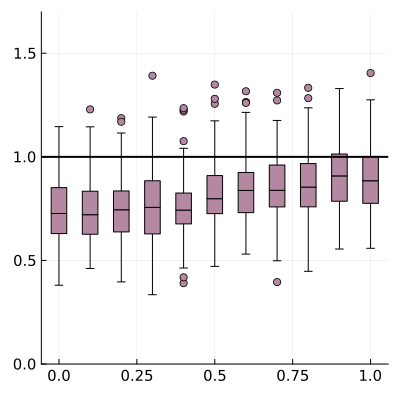

In [213]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with jointly inferred fitness of mutants 
# Estimated mutant fitness
m = "hom_joint_fit"
P_rho_A = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.fitness_mutants_s, lab="", c=my_col[16], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.7))
hline!([1], c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness")
#scatter!([0], [-1], lab="Permissive and stressful condition", c=my_col[16], marker=:square)

In [214]:
savefig(P_mean_het, "figures/Figure_A_6A1.pdf")
savefig(P_r, "figures/Figure_A_6B1.pdf")
savefig(P_mean_hom, "figures/Figure_A_6A2.pdf")
savefig(P_rho, "figures/Figure_A_6B2.pdf")
savefig(P_mean_hom_A, "figures/Figure_A_6A3.pdf")
savefig(P_rho_A, "figures/Figure_A_6B3.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_6B3.pdf"

### Appendix Figure: Estimation of mutation-rate increase, fraction of response-on subpopulation and mutation-rate heterogeneity

In [54]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
f_on_true = Vector{Float64}(undef, J)
Nf_s = Vector{Float64}(undef, J)
switching = true_para.switchings[1]
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    f_on_true[j] = f_on
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
    Nf_s[j] = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[1]
end
R = true_para.number_fluctuation_assays[1];

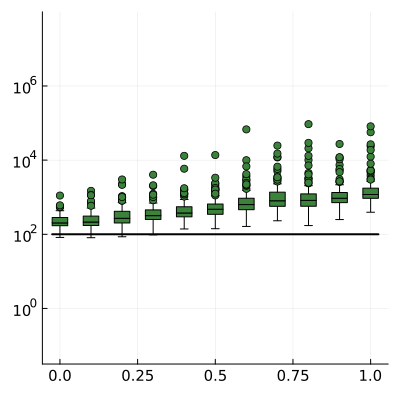

In [55]:
# Reading and plotting the inferred parameters
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# Estimated mutation-rate increase
m = "het_unknown_fraction"
P_inc_0 = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[6], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, tickfontsize=10, ylim=(10^-1.5, 10^8), yticks=([10^0, 10^2, 10^4, 10^6]))
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutation-rate increase")
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="")

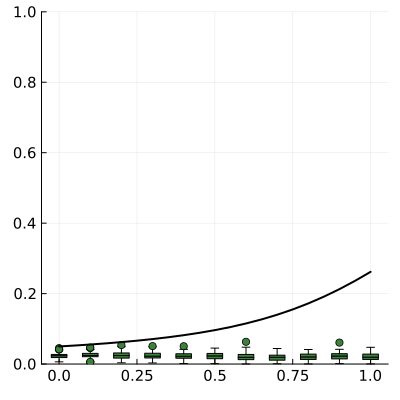

In [56]:
# Estimated fraction of response-on subpopulation
P_f_0 = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.fraction_on , lab="", c=my_col[6], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), tickfontsize=10, ylim=(0,1))
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. fraction of response-on subpopulation")
plot!(collect(1:J), f_on_true, c=:black, width=2, lab="")


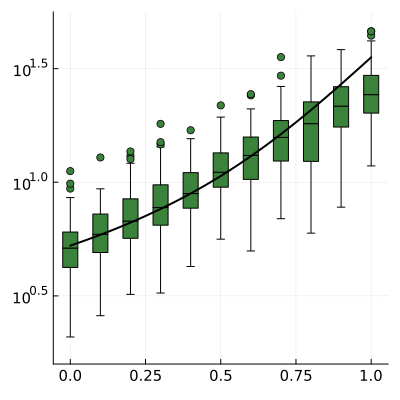

In [57]:
# Estimated mutation-rate heterogeneity
P_het_0 = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on .* inferred_para.fraction_on ./ (inferred_para.mutation_rate_off .* (1 .- inferred_para.fraction_on)), lab="", c=my_col[6], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, tickfontsize=10, ylim=(10^0.2, 10^1.75))
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutation-rate heterogeneity")
plot!(collect(1:J), mu_on_true .* f_on_true ./ (mu_off_true .* (1 .- f_on_true)), c=:black, width=2, lab="")

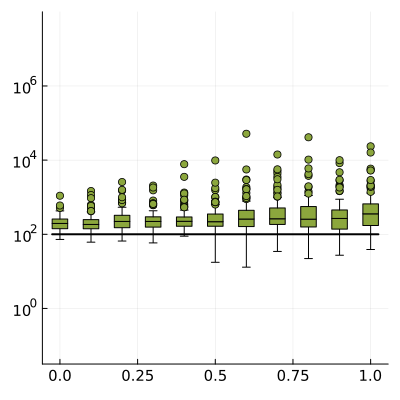

In [58]:
# Reading and plotting the inferred parameters
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# Estimated mutation-rate increase
m = "het_unknown_fraction_infer_div"
P_inc_infer = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=my_col[8], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, tickfontsize=10, ylim=(10^-1.5, 10^8), yticks=([10^0, 10^2, 10^4, 10^6]))
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutation-rate increase")
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="")

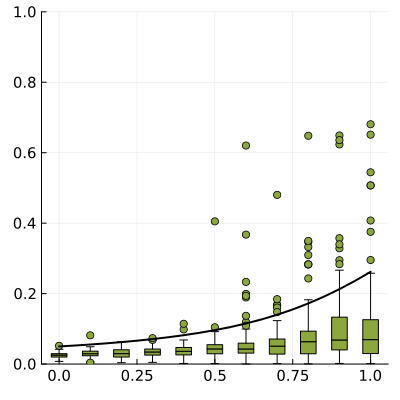

In [59]:
# Estimated fraction of response-on subpopulation
P_f_infer = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.fraction_on , lab="", c=my_col[8], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), tickfontsize=10, ylim=(0,1))
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. fraction of response-on subpopulation")
plot!(collect(1:J), f_on_true, c=:black, width=2, lab="")


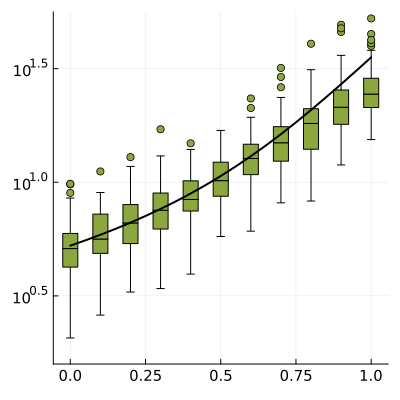

In [60]:
# Estimated mutation-rate heterogeneity
P_het_infer = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.mutation_rate_on .* inferred_para.fraction_on ./ (inferred_para.mutation_rate_off .* (1 .- inferred_para.fraction_on)), lab="", c=my_col[8], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, tickfontsize=10, ylim=(10^0.2, 10^1.75))
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutation-rate heterogeneity")
plot!(collect(1:J), mu_on_true .* f_on_true ./ (mu_off_true .* (1 .- f_on_true)), c=:black, width=2, lab="")

In [61]:
savefig(P_inc_0, "figures/Figure_A_7A1.pdf")
savefig(P_f_0, "figures/Figure_A_7B1.pdf")
savefig(P_het_0, "figures/Figure_A_7C1.pdf")
savefig(P_inc_infer, "figures/Figure_A_7A2.pdf")
savefig(P_f_infer, "figures/Figure_A_7B2.pdf")
savefig(P_het_infer, "figures/Figure_A_7C2.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_7C2.pdf"

### Appendix Figures: Model selection when the mutation-rate increase is ~O(10) 

In [229]:
# Reading the (true) input parameters
p = "range_rel-div-on_inc-10"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];
     

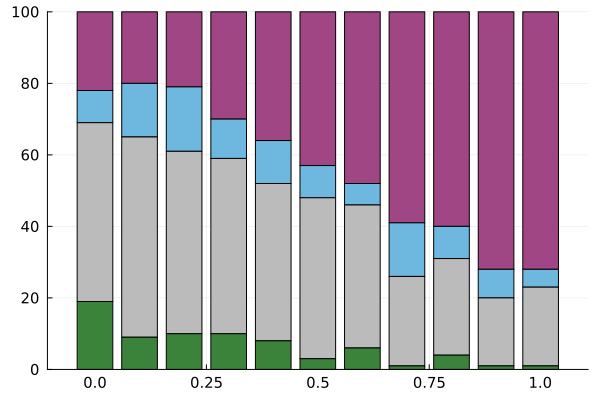

In [235]:
# Reading AIC values and selecting a model
# (i) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (ii) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
# (iii) Homogeneous-response model with fitness of mutants set to one
# (iv) Homogeneous-response model with fitnesses of mutants permissive/stressful inferred
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_infer_fit"
select_het_1 = Vector{Int}(undef, J)
select_het_2 = Vector{Int}(undef, J)
select_hom_1 = Vector{Int}(undef, J)
select_hom_2 = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv")).AIC
    AIC_12 = AIC_1 .- AIC_2
    AIC_hom = minimum([AIC_1 AIC_2], dims=2)
    AIC_3 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv")).AIC
    AIC_4 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv")).AIC
    AIC_34 = AIC_3 .- AIC_4
    AIC_het = minimum([AIC_3 AIC_4], dims=2)
    AIC_diff = AIC_het .- AIC_hom
    select_hom_1[j] = sum( (AIC_diff .> 2) .* (AIC_12 .< 0))
    select_hom_2[j] = sum( (AIC_diff .> 2) .* (AIC_12 .> 0))
    select_het_1[j] = sum( (AIC_diff .< -2) .* (AIC_34 .< 0))
    select_het_2[j] = sum( (AIC_diff .< -2) .* (AIC_34 .> 0))
    select_none[j] = R - select_hom_1[j] - select_hom_2[j] - select_het_1[j] - select_het_2[j]
end
P_AIC_10 = groupedbar([select_hom_1[1:2:J] select_hom_2[1:2:J] select_none[1:2:J] select_het_1[1:2:J] select_het_2[1:2:J]], bar_position=:stack, c=[my_col[14] my_col[12] my_col[17] my_col[6] my_col[8]], label=["Homogeneous response (mutant fitness set to one)" "Homogeneous response (mutant fitnesses permissive/stressful inferred)" "None" "Heterogeneous response (rel. fitness set to zero)" "Heterogeneous response (rel. fitness inferred)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=10)
plot!(legend=false)
#plot!(xlab="Relative fitness of response-on cells", ylab="Percentage of simulations", legend=:outertop, legend_title="Preferred model")

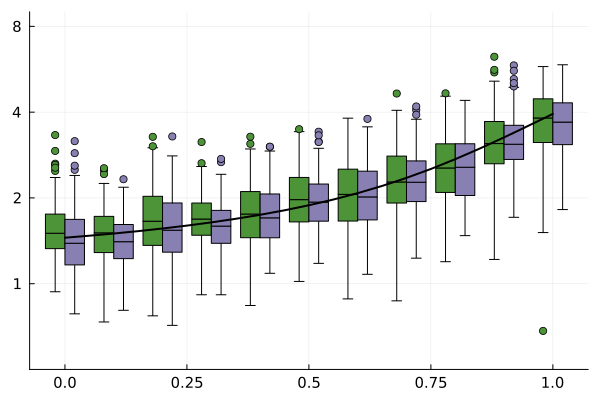

In [236]:
# Reading and plotting the inferred parameters
# Estimation methods:
# (i) Heterogeneous-response model (unknown f_on)
# (ii) Homogeneous-response model
# Estimated population-wide mutation-rate increase 
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_infer_fit"
P_mean_10 = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv"))
    inferred_para_het_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv"))
    inferred_para_het_1.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het_2.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het = vcat(subset(inferred_para_het_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_het_2, :AIC_diff => ByRow(a->a>0.)))
    inferred_para_hom_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv"))
    inferred_para_hom_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv"))
    inferred_para_hom_1.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom_2.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom = vcat(subset(inferred_para_hom_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_hom_2, :AIC_diff => ByRow(a->a>0.)))
    boxplot!([j-0.4], (inferred_para_het.mutation_rate_on .* inferred_para_het.fraction_on .+ inferred_para_het.mutation_rate_off .* (1 .- inferred_para_het.fraction_on)) ./ inferred_para_het.mutation_rate_off, lab="", c=my_col[7])
    boxplot!([j+0.4], inferred_para_hom.mutation_rate_s ./ inferred_para_hom.mutation_rate_p, lab="", c=my_col[13])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(0.5, 9), yticks=([1,2,4,8], [1,2,4,8]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Best-fitting heterogeneous-response model", c=my_col[7], marker=:square)
#scatter!([0], [0.1], lab="Best-fitting homogeneous-response model", c=my_col[13], marker=:square)

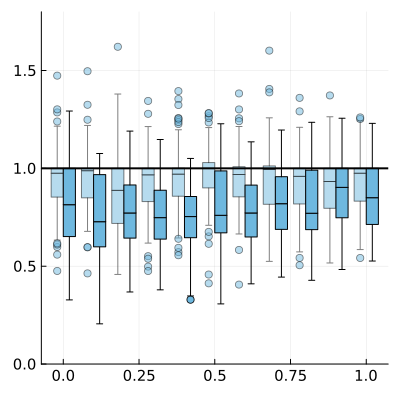

In [237]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with fitnesses of mutants permissive/stressful inferred
# Estimated mutant fitness
m = "hom_infer_fit"
P_rho_10 = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j-0.4], inferred_para.fitness_mutants_p, lab="", c=my_col[12], alpha=0.5)
    boxplot!([j+0.4], inferred_para.fitness_mutants_s, lab="", c=my_col[12])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.8))
hline!([1], c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness")
#scatter!([0], [-1], lab="Permissive condition", c=:red, alpha=0.5, marker=:square)
#scatter!([0], [-1], lab="Stressful condition", c=:red, marker=:square)

In [238]:
savefig(P_AIC_10, "figures/Figure_A_8A.pdf")
savefig(P_mean_10, "figures/Figure_A_8B.pdf")
savefig(P_rho_10, "figures/Figure_A_8C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_8C.pdf"

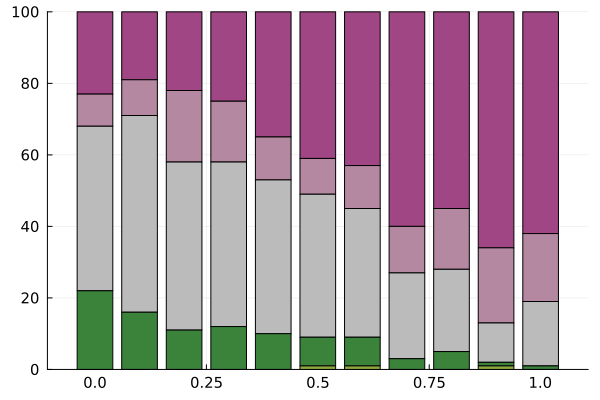

In [246]:
# Reading AIC values and selecting a model
# (i) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (ii) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
# (iii) Homogeneous-response model with fitness of mutants set to one
# (iv) Homogeneous-response model with jointly inferred fitness of mutants
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_joint_fit"
select_het_1 = Vector{Int}(undef, J)
select_het_2 = Vector{Int}(undef, J)
select_hom_1 = Vector{Int}(undef, J)
select_hom_2 = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv")).AIC
    AIC_12 = AIC_1 .- AIC_2
    AIC_hom = minimum([AIC_1 AIC_2], dims=2)
    AIC_3 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv")).AIC
    AIC_4 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv")).AIC
    AIC_34 = AIC_3 .- AIC_4
    AIC_het = minimum([AIC_3 AIC_4], dims=2)
    AIC_diff = AIC_het .- AIC_hom
    select_hom_1[j] = sum( (AIC_diff .> 2) .* (AIC_12 .< 0))
    select_hom_2[j] = sum( (AIC_diff .> 2) .* (AIC_12 .> 0))
    select_het_1[j] = sum( (AIC_diff .< -2) .* (AIC_34 .< 0))
    select_het_2[j] = sum( (AIC_diff .< -2) .* (AIC_34 .> 0))
    select_none[j] = R - select_hom_1[j] - select_hom_2[j] - select_het_1[j] - select_het_2[j]
end
P_AIC_10_A = groupedbar([select_hom_1[1:2:J] select_hom_2[1:2:J] select_none[1:2:J] select_het_1[1:2:J] select_het_2[1:2:J]], bar_position=:stack, c=[my_col[14] my_col[16] my_col[17] my_col[6] my_col[8]], label=["Homogeneous response (mutant fitness set to one)" "Homogeneous response (constrained mutant fitness inferred)" "None" "Heterogeneous response (rel. fitness set to zero)" "Heterogeneous response (rel. fitness inferred)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=10)
plot!(legend=false)
#plot!(xlab="Relative fitness of response-on cells", ylab="Percentage of simulations", legend=:outertop, legend_title="Preferred model")

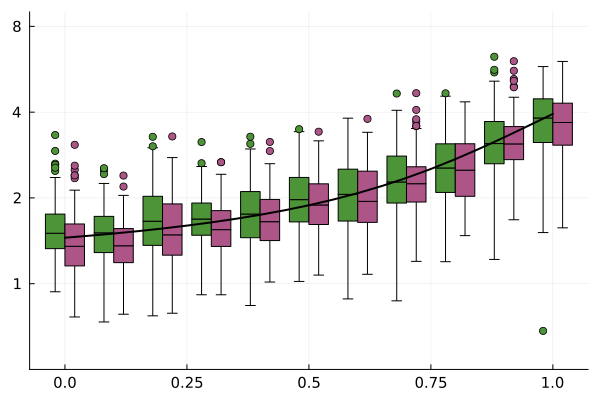

In [247]:
# Reading and plotting the inferred parameters
# Estimation methods:
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with fitness of mutants permissive/stressful inferred
# Estimated population-wide mutation-rate increase 
m_het_1 = "het_unknown_fraction"
m_het_2 = "het_unknown_fraction_infer_div"
m_hom_1 = "hom_no_fit"
m_hom_2 = "hom_joint_fit"
P_mean_10_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_1*"_$j.csv"))
    inferred_para_het_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het_2*"_$j.csv"))
    inferred_para_het_1.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het_2.AIC_diff = inferred_para_het_1.AIC .- inferred_para_het_2.AIC
    inferred_para_het = vcat(subset(inferred_para_het_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_het_2, :AIC_diff => ByRow(a->a>0.)))
    inferred_para_hom_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_1*"_$j.csv"))
    inferred_para_hom_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_hom_2*"_$j.csv"))
    inferred_para_hom_1.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom_2.AIC_diff = inferred_para_hom_1.AIC .- inferred_para_hom_2.AIC
    inferred_para_hom = vcat(subset(inferred_para_hom_1, :AIC_diff => ByRow(a->a<=0.)), subset(inferred_para_hom_2, :AIC_diff => ByRow(a->a>0.)))
    boxplot!([j-0.4], (inferred_para_het.mutation_rate_on .* inferred_para_het.fraction_on .+ inferred_para_het.mutation_rate_off .* (1 .- inferred_para_het.fraction_on)) ./ inferred_para_het.mutation_rate_off, lab="", c=my_col[7])
    boxplot!([j+0.4], inferred_para_hom.mutation_rate_s ./ inferred_para_hom.mutation_rate_p, lab="", c=my_col[15])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(0.5, 9), yticks=([1,2,4,8], [1,2,4,8]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Est. population mean mutation-rate increase", legend=:topleft)
#scatter!([0], [0.1], lab="Best-fitting heterogeneous-response model", c=my_col[7], marker=:square)
#scatter!([0], [0.1], lab="Best-fitting homogeneous-response model", c=my_col[15], marker=:square)

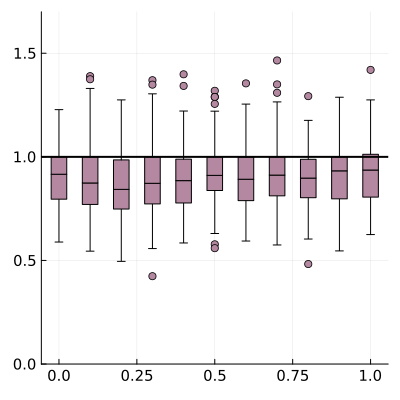

In [248]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with jointly inferred fitness of mutants 
# Estimated mutant fitness
m = "hom_joint_fit"
P_rho_10_A = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!([j], inferred_para.fitness_mutants_s, lab="", c=my_col[16], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.7))
hline!([1], c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness")
#scatter!([0], [-1], lab="Permissive and stressful condition", c=my_col[16], marker=:square)

In [249]:
savefig(P_AIC_10_A, "figures/Figure_A_9A.pdf")
savefig(P_mean_10_A, "figures/Figure_A_9B.pdf")
savefig(P_rho_10_A, "figures/Figure_A_9C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM-exp/figures/Figure_A_9C.pdf"

### Appendix Figure: Testing the validity of the assumption that the response-on subpopulation can be treated deterministically

In [79]:
# Reading the (true) input parameters
p = "range_switching"
p2 = "range_rel-div-on_inc-100"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) 
range_para_2 = collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1])
J1 = length(range_para_1)
J2 = length(range_para_2)
f0_on = [0., 0.01, 1.]
Nf = 10^9
N0 = true_para_1.initial_population_size[1]
div_off = true_para_1.divisions_off[1]
mu_off = true_para_1.mutations_off[1]
mu_on = true_para_1.mutations_on[1];

In [93]:
# Reading and plotting the output data
# Comparing with determinist equation for the size of the response-on subpopulation
include("population_dynamics.jl")
# Relative error and coefficient of variation across the simulations
RE_alpha_div_t1 = Matrix{Float64}(undef, (J2, J1))
CV_alpha_div_t1 = Matrix{Float64}(undef, (J2, J1))
RE_alpha_div_tf = Matrix{Float64}(undef, (J2, J1))
CV_alpha_div_tf = Matrix{Float64}(undef, (J2, J1))
f = 3
for j2 = 1:J2
    p_folder = "/rel-div_$j2"
    for j1 = 1:J1
        f0_on[end] = range_para_1[j1]/div_off
        N_on_t1 = DataFrame(CSV.File("output_data/"*p*p_folder*"/popsize_nm_on_t1_$j1.csv"))
        N_on_tf = DataFrame(CSV.File("output_data/"*p*p_folder*"/popsize_nm_on_tf_$j1.csv"))
        tf = t_final(N0, div_off-range_para_1[j1], Nf) 
        t1 = t_first_m(N0, div_off-range_para_1[j1], mu_off*(1-f0_on[f])+mu_on*f0_on[f])
        RE_alpha_div_t1[j2, j1] = (median(N_on_t1[:,f]) - pop_size(t1, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])) / pop_size(t1, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])
        RE_alpha_div_tf[j2, j1] = (median(N_on_tf[:,f]) - pop_size(tf, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])) / pop_size(tf, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])
        CV_alpha_div_t1[j2, j1] = std(N_on_t1[:,f]) / mean(N_on_t1[:,f])
        CV_alpha_div_tf[j2, j1] = std(N_on_tf[:,f]) / mean(N_on_tf[:,f])
    end
end

Initial fraction = 0.1

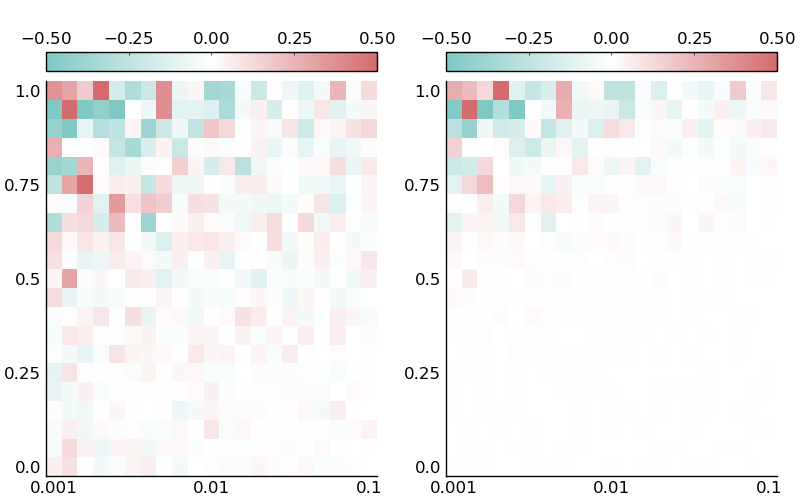

In [94]:
pyplot()
c_max = 0.5
c_min = -0.5
P_RE_t1 = plot(size=(400,500))
heatmap!(100 .*RE_alpha_div_t1, c=cgrad([my_col[11], :white, my_col[4]], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max), cb=:top, colorbar_tickfontsize=12)
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Early time point", colorbar_title="Relative error in % (median)", xlab="Relative switching rate", ylab="Relative division rate", rightmargin=15mm)
P_RE_tf = plot(size=(400,500))
heatmap!(100 .*RE_alpha_div_tf, c=cgrad([my_col[11], :white, my_col[4]], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max), cb=:top, colorbar_tickfontsize=12)
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Late time point", colorbar_title="Relative error in % (median)", xlab="Relative switching rate", ylab="Relative division rate", rightmargin=15mm)
print("Initial fraction = $(f0_on[f])")
plot(P_RE_t1, P_RE_tf,size=(800,500))

Initial fraction = 0.1

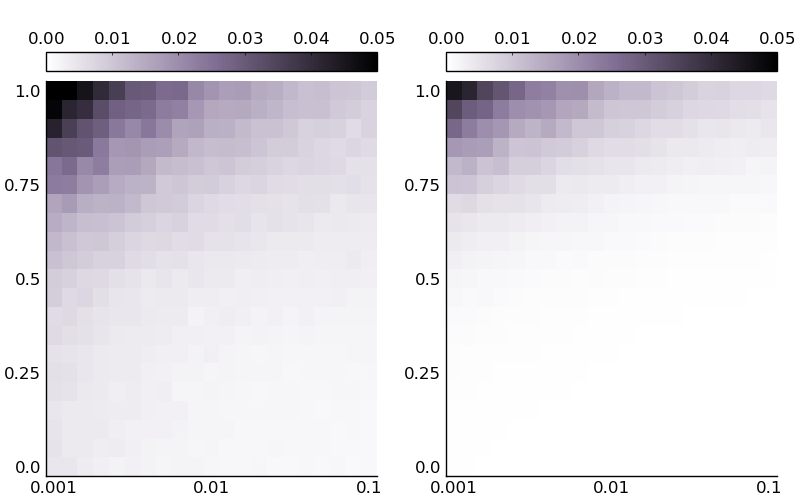

In [95]:
c_max = 0.05
P_CV_t1 = plot(size=(400,500))
heatmap!(CV_alpha_div_t1, c=cgrad([:white, my_col[2], :black]), clim=(0, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12, cb=:top, colorbar_tickfontsize=12)
#plot!(title="Early time point", colorbar_title="Coefficient of variation", xlab="Relative switching rate", ylab="Relative division rate")
P_CV_tf = plot(size=(400,500))
heatmap!(CV_alpha_div_tf, c=cgrad([:white, my_col[2], :black]), clim=(0, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12, cb=:top, colorbar_tickfontsize=12)
#plot!(title="Late time point", colorbar_title="Coefficient of variation", xlab="Relative switching rate", ylab="Relative division rate")
print("Initial fraction = $(f0_on[f])")
plot(P_CV_t1, P_CV_tf,size=(800,500))

In [96]:
savefig(P_RE_t1, "figures/Figure_A_1A$f.png")
savefig(P_RE_tf, "figures/Figure_A_1B$f.png")
savefig(P_CV_t1, "figures/Figure_A_1C$f.png")
savefig(P_CV_tf, "figures/Figure_A_1D$f.png")
gr()

Plots.GRBackend()